In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
%pip install "tornado>=5" 
%pip install "dask[complete]"

clear_output()

In [3]:
!pip install shap
!pip install plotly-express
!pip install pingouin

clear_output()

In [4]:
import dask

In [5]:
import pandas as pd 
import numpy as np
import dask.dataframe as dd 
import dask.array as da 

import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

#plt.style.use('fivethirtyeight')

# Statistical Analysis
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.stats import pearsonr, ttest_ind, norm, chi2_contingency, fisher_exact, spearmanr

import scipy.stats as stats

#Machine Learning Packages
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import shap
shap.initjs()

# Notebook display modifications
from IPython.core.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Data cleaning

In [7]:
filename = "drive/My Drive/Colab Notebooks/COVID/COVID-19_Case_Surveillance_Public_Use_Data.csv"

df = pd.read_csv(filename)
df.head()

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/01/01,2021/01/31,2020/01/01,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Missing,Missing,No,Missing
1,2020/01/01,2021/02/02,2020/01/01,NaN,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,Missing,Missing,No,Missing
2,2020/01/02,2021/01/27,2020/01/02,NaN,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,Missing,Missing,No,Missing
3,2020/01/02,2021/02/02,2020/01/02,NaN,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,Missing,Missing,No,Missing
4,2021/01/01,2020/01/03,2020/01/03,2021/01/01,Laboratory-confirmed case,Male,0 - 9 Years,"White, Non-Hispanic",No,Missing,No,Yes


In [8]:
def yn_to_binary(s: str):
  # Changes Yes/No to 1/0
  return 1 if (s == "Yes") else 0 

df = df.rename(columns={"cdc_case_earliest_dt ": "cdc_case_earliest_dt"})

df = df.drop(columns=["cdc_report_dt"], axis=1) # deprecated
df = df.dropna()

df["cdc_case_earliest_dt"] = pd.to_datetime(df["cdc_case_earliest_dt"])
df["pos_spec_dt"] = pd.to_datetime(df["pos_spec_dt"])
df["onset_dt"] = pd.to_datetime(df["onset_dt"])

df['symptom_development_time_days'] = pd.to_timedelta(df['onset_dt'] - df['cdc_case_earliest_dt']).dt.days
df = df.drop(columns=["pos_spec_dt", "onset_dt"], axis=1)

df["current_status"] = df["current_status"].apply(lambda v: 1 if (v == "Laboratory-confirmed case") else 0)
df["sex"] = df["sex"].apply(lambda v: 1 if (v == "Male") else 0)
df["hosp_yn"] = df["hosp_yn"].apply(yn_to_binary)
df["icu_yn"] = df["icu_yn"].apply(yn_to_binary)

# Drop rows with these missing/unknown values
list_of_cols = ["sex", "age_group", "race_ethnicity_combined", "hosp_yn", "icu_yn", "death_yn", "medcond_yn"]
for col in list_of_cols:
  df = df[(df[col] != "Missing") & (df[col] != "Unknown")]

df["death_yn"] = df["death_yn"].apply(yn_to_binary)
df["medcond_yn"] = df["medcond_yn"].apply(yn_to_binary)

df = df.reset_index().drop(columns=["index"])

In [9]:
# Dummy variables for race and age
df = pd.get_dummies(df, columns=["age_group", "race_ethnicity_combined"], prefix=["age", "race"])

# Rename columns
df.rename(columns = {
    'race_American Indian/Alaska Native, Non-Hispanic':'race_American Indian/Alaska Native',
    'race_Asian, Non-Hispanic': 'race_Asian',
    'race_Black, Non-Hispanic': 'race_Black',
    'race_Multiple/Other, Non-Hispanic': 'race_Multiple/Other',
    'race_Native Hawaiian/Other Pacific Islander, Non-Hispanic': 'race_Native Hawaiian/Other Pacific Islander',
    'race_White, Non-Hispanic': 'race_White'
}, inplace=True)

In [10]:
df.head()

,cdc_case_earliest_dt,current_status,sex,hosp_yn,icu_yn,death_yn,medcond_yn,symptom_development_time_days,age_0 - 9 Years,age_10 - 19 Years,age_20 - 29 Years,age_30 - 39 Years,age_40 - 49 Years,age_50 - 59 Years,age_60 - 69 Years,age_70 - 79 Years,age_80+ Years,race_American Indian/Alaska Native,race_Asian,race_Black,race_Hispanic/Latino,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White
0,2021-01-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2021-01-08,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2020-03-05,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2020-03-31,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2020-03-29,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [11]:
# Reorder columns
df2 = df[['cdc_case_earliest_dt','symptom_development_time_days',
             'current_status','medcond_yn','sex','age_0 - 9 Years','age_10 - 19 Years','age_20 - 29 Years',
             'age_30 - 39 Years','age_40 - 49 Years','age_50 - 59 Years','age_60 - 69 Years', 'age_70 - 79 Years', 
             'age_80+ Years','race_Hispanic/Latino','race_Black','race_White','race_Multiple/Other',
             'race_Native Hawaiian/Other Pacific Islander','race_Asian','race_American Indian/Alaska Native',
             'hosp_yn','icu_yn','death_yn']]
df2.head()

,cdc_case_earliest_dt,symptom_development_time_days,current_status,medcond_yn,sex,age_0 - 9 Years,age_10 - 19 Years,age_20 - 29 Years,age_30 - 39 Years,age_40 - 49 Years,age_50 - 59 Years,age_60 - 69 Years,age_70 - 79 Years,age_80+ Years,race_Hispanic/Latino,race_Black,race_White,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_Asian,race_American Indian/Alaska Native,hosp_yn,icu_yn,death_yn
0,2021-01-01,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2021-01-08,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2020-03-05,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2020-03-31,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2020-03-29,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
# export cleaned data as csv
df2.to_csv("covid_full_clean.csv", index=False)

# ML Models

In [13]:
# Dictionary to save accuracy scores for each classifier models
scores = {}

In [14]:
# Import data
test = pd.read_csv("covid_full_clean.csv")
test.dtypes

cdc_case_earliest_dt                           object
symptom_development_time_days                   int64
current_status                                  int64
medcond_yn                                      int64
sex                                             int64
age_0 - 9 Years                                 int64
age_10 - 19 Years                               int64
age_20 - 29 Years                               int64
age_30 - 39 Years                               int64
age_40 - 49 Years                               int64
age_50 - 59 Years                               int64
age_60 - 69 Years                               int64
age_70 - 79 Years                               int64
age_80+ Years                                   int64
race_Hispanic/Latino                            int64
race_Black                                      int64
race_White                                      int64
race_Multiple/Other                             int64
race_Native Hawaiian/Other P

In [15]:
# Define X and y
X = df.drop(columns=["death_yn", "cdc_case_earliest_dt"], axis=1)
y = df["death_yn"]

# Split data into validation and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(664405, 22) (664405,) (284746, 22) (284746,)


Linear Discriminant Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,266430,9600
Actually Died,2765,5951




Accuracy score:  0.9566
Recall Score:  0.6828
Precision:  0.3827




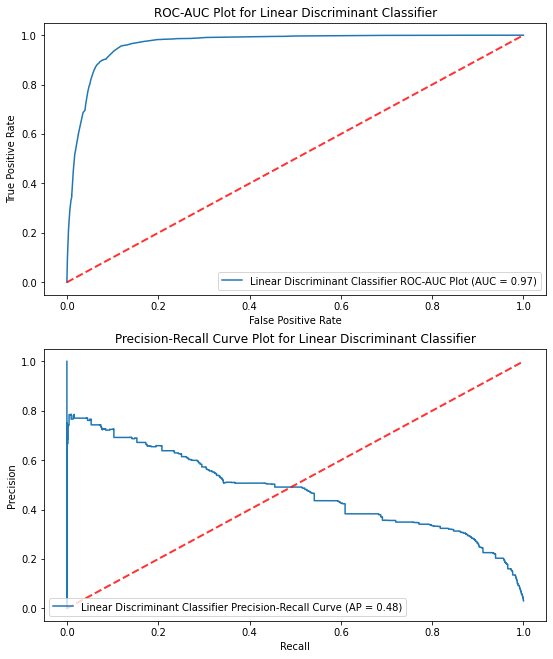

Variables are collinear


Quadratic Discriminant Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,230333,45697
Actually Died,363,8353




Accuracy score:  0.8382
Recall Score:  0.9584
Precision:  0.1545




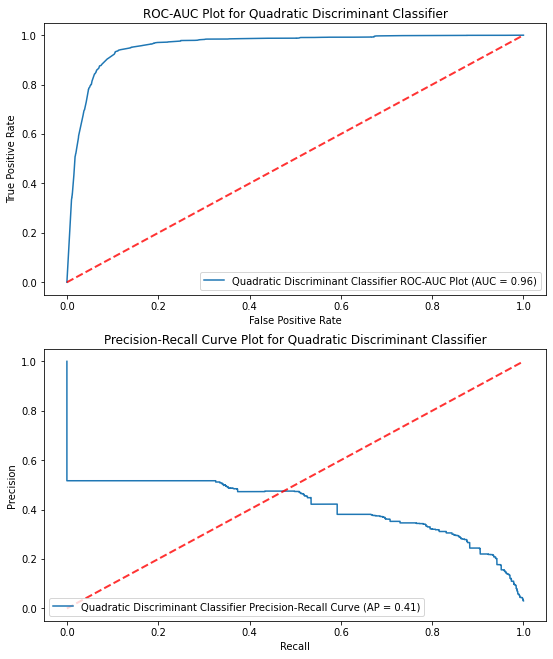

Logisitic Regression Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,273221,2809
Actually Died,5245,3471




Accuracy score:  0.9717
Recall Score:  0.3982
Precision:  0.5527




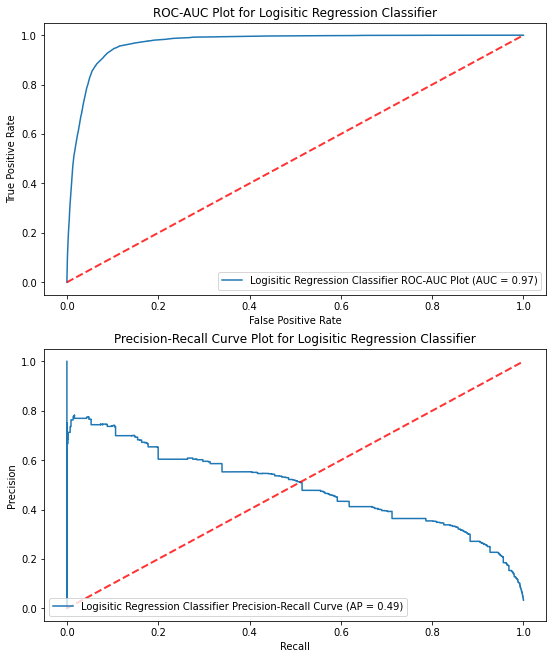

Gaussian Naive Bayes Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,230749,45281
Actually Died,375,8341




Accuracy score:  0.8397
Recall Score:  0.957
Precision:  0.1556




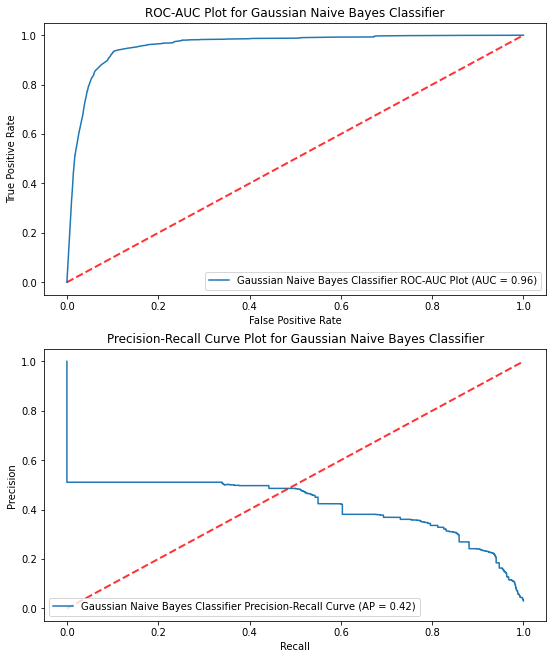

Decision Tree Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,274651,1379
Actually Died,6466,2250




Accuracy score:  0.9724
Recall Score:  0.2581
Precision:  0.62




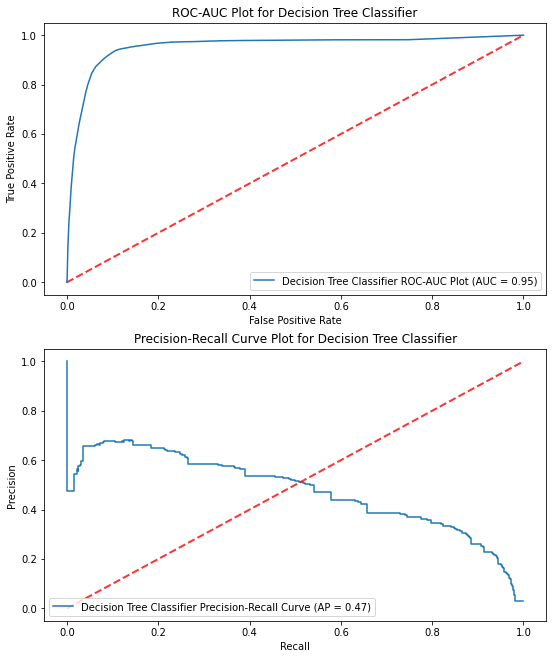

Stochastic Gradient Descent Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,273874,2156
Actually Died,5994,2722




Accuracy score:  0.9714
Recall Score:  0.3123
Precision:  0.558




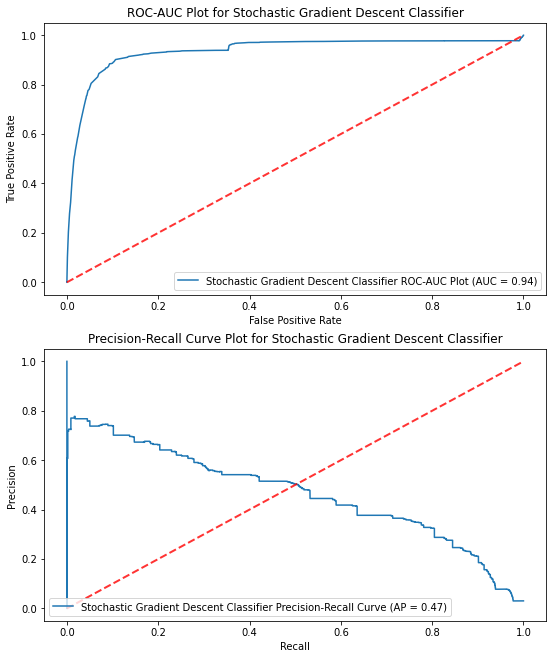

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, roc_auc_score, roc_curve, plot_precision_recall_curve, plot_roc_curve

classifiers = {
    "Linear Discriminant Classifier":          LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Classifier":       QuadraticDiscriminantAnalysis(),
    "Logisitic Regression Classifier":          LogisticRegression(solver='lbfgs',max_iter=1000),
    "Gaussian Naive Bayes Classifier":         GaussianNB(),
    "Decision Tree Classifier":                DecisionTreeClassifier(),
    "Stochastic Gradient Descent Classifier":  SGDClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_score = classifier.predict(X_test)
    print("="*125)
    print(key, "\n")
    print("Confusion Matrix: \n")
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_score))
    conf_mat.index = ['Actually Survived', 'Actually Died']
    conf_mat.columns = ['Predicted Survived', 'Predicted Died']
    display(conf_mat)
    print("\n")
    accuracy = round(accuracy_score(y_test, y_score), 4)
    print("Accuracy score: ", accuracy)
    print("Recall Score: ", round(recall_score(y_test, y_score), 4))
    print("Precision: ", round(precision_score(y_test, y_score), 4))
    print("\n")
    
    fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
    axs[0].set_title("ROC-AUC Plot for " + key)
    plot_roc_curve(classifier, X_test, y_test, ax=axs[0], name=key+" ROC-AUC Plot")
    axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)

    axs[1].set_title("Precision-Recall Curve Plot for " + key)
    plot_precision_recall_curve(classifier, X_test, y_test, ax=axs[1],name=key+" Precision-Recall Curve")
    axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)

    scores[key] = accuracy

    plt.show()


Random Forest Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,274643,1387
Actually Died,6454,2262




Accuracy score:  0.9725
Recall Score:  0.2595
Precision:  0.6199




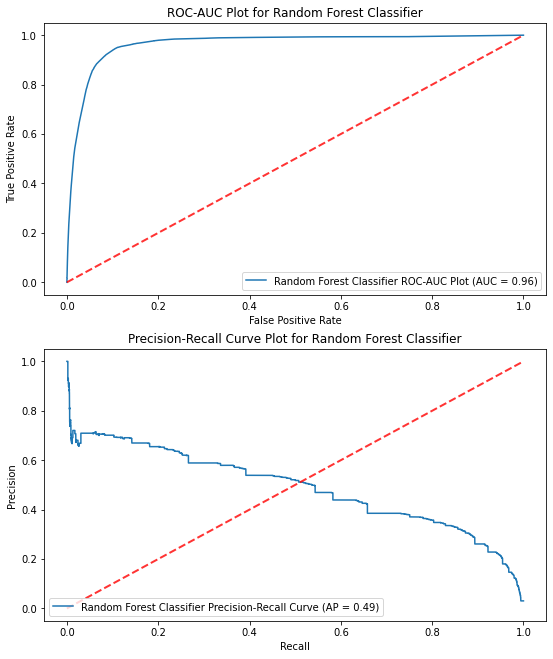

Gradient Boosting Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,274692,1338
Actually Died,6418,2298




Accuracy score:  0.9728
Recall Score:  0.2637
Precision:  0.632




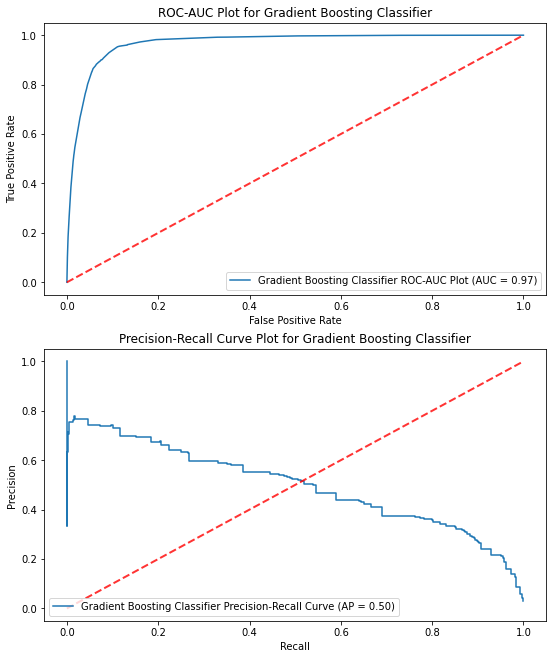

XGBoost Classifier 

Confusion Matrix: 



,Predicted Survived,Predicted Died
Actually Survived,274995,1035
Actually Died,6695,2021




Accuracy score:  0.9729
Recall Score:  0.2319
Precision:  0.6613




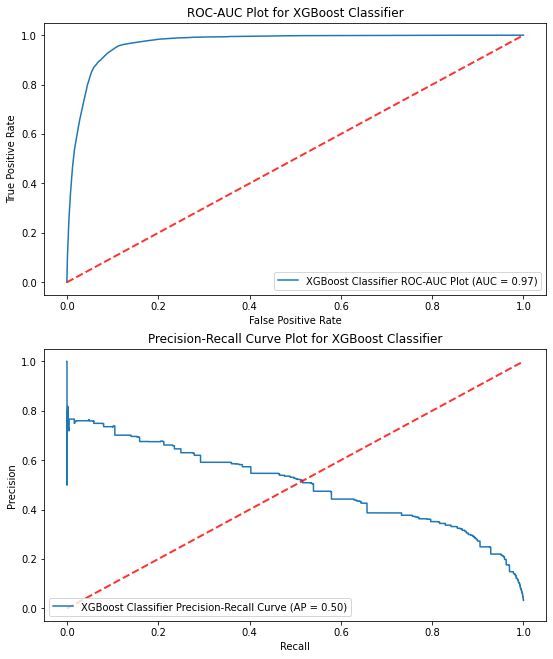

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

ensemble_classifiers = {
    "Random Forest Classifier" :            RandomForestClassifier(),
    "Gradient Boosting Classifier" :        GradientBoostingClassifier(learning_rate=0.05),
    "XGBoost Classifier":                   XGBClassifier()
}

for key, classifier in ensemble_classifiers.items():
    classifier.fit(X_train, y_train)
    y_score = classifier.predict(X_test)
    print("="*125)
    print(key, "\n")
    print("Confusion Matrix: \n")
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_score))
    conf_mat.index = ['Actually Survived', 'Actually Died']
    conf_mat.columns = ['Predicted Survived', 'Predicted Died']
    display(conf_mat)
    print("\n")
    accuracy = round(accuracy_score(y_test, y_score), 4)
    print("Accuracy score: ", accuracy)
    print("Recall Score: ", round(recall_score(y_test, y_score), 4))
    print("Precision: ", round(precision_score(y_test, y_score), 4))
    print("\n")
    
    fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
    axs[0].set_title("ROC-AUC Plot for " + key)
    plot_roc_curve(classifier, X_test, y_test, ax=axs[0], name=key+" ROC-AUC Plot")
    axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)

    axs[1].set_title("Precision-Recall Curve Plot for " + key)
    plot_precision_recall_curve(classifier, X_test, y_test, ax=axs[1],name=key+" Precision-Recall Curve")
    axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    
    scores[key] = accuracy

    plt.show()



# SHAP Values

In [18]:
import xgboost

# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 141.71524896193728
0:[hosp_yn<1] yes=1,no=2,missing=1,gain=4853.42578,cover=949151
	1:[age_80+ Years<1] yes=3,no=4,missing=3,gain=989.924988,cover=867419
		3:[age_70 - 79 Years<1] yes=7,no=8,missing=7,gain=50.0197754,cover=842789
			7:leaf=0.00167196454,cover=799060
			8:leaf=0.0364060476,cover=43729
		4:[medcond_yn<1] yes=9,no=10,missing=9,gain=94.6190186,cover=24630
			9:leaf=0.0728278384,cover=4339
			10:leaf=0.235523134,cover=20291
	2:[icu_yn<1] yes=5,no=6,missing=5,gain=1438.04102,cover=81732
		5:[age_80+ Years<1] yes=11,no=12,missing=11,gain=982.778809,cover=61615
			11:leaf=0.12505585,cover=49242
			12:leaf=0.440313578,cover=12373
		6:[medcond_yn<1] yes=13,no=14,missing=13,gain=197.069336,cover=20117
			13:leaf=0.252026796,cover=2837
			14:leaf=0.536400437,cover=17280



In [19]:
# Checking that SHAP values add to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

5.9604645e-08

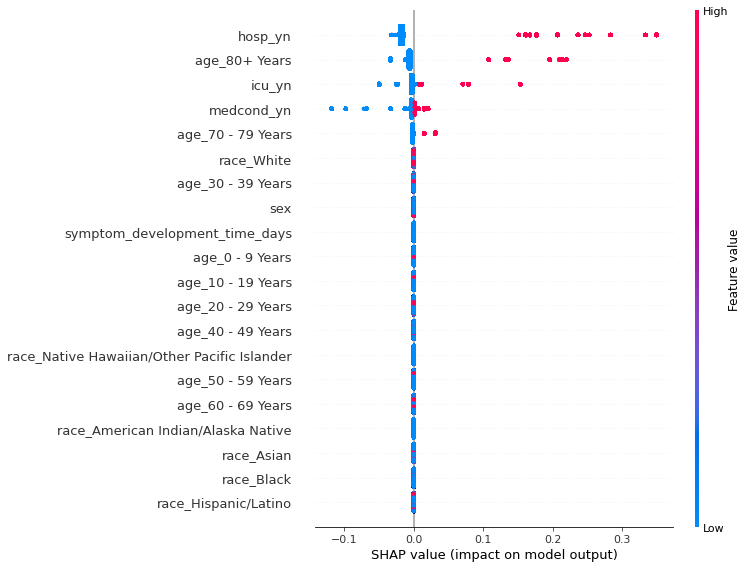

In [20]:
# SHAP feature value from whole dataset
shap.summary_plot(shap_values, X)

In [21]:
shap.initjs()
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[1,:],link='logit')

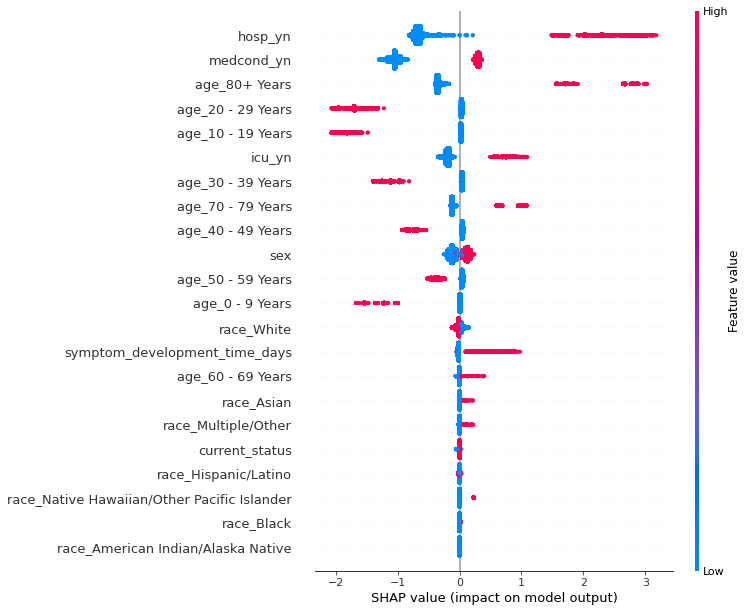

In [22]:
# SHAP plot from X_test
shap.summary_plot(shap_values, X_test,title='SHAP Values for Each Feature', max_display=len(X_test.columns))

# Summary

The features that are most significant in determining death from COVID are:


1.   Whether you are hospitalized
2.   Whether you have a medical condition
3.   Age (70-79, 80+)
4.   Whether you were admitted to the ICU




In [23]:
import operator

# Find accuracy scores for all classifiers
sorted_score = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
for classifier, score in sorted_score:
  print(f"{classifier} -- {score}")

XGBoost Classifier -- 0.9729
Gradient Boosting Classifier -- 0.9728
Random Forest Classifier -- 0.9725
Decision Tree Classifier -- 0.9724
Logisitic Regression Classifier -- 0.9717
Stochastic Gradient Descent Classifier -- 0.9714
Linear Discriminant Classifier -- 0.9566
Gaussian Naive Bayes Classifier -- 0.8397
Quadratic Discriminant Classifier -- 0.8382


The most accurate models were:


*   XGBoost classifier
*   Gradient Boosting Classifier
*   Random Forest Classifier
*   Decision Tree Classifier